# Data Analysis

Objectives:

- [x] Determine if there has been a slow down in productivity growth.
- [ ] Determine if there is a relationship between productivity growth and creative destruction.

## Load in the data

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

In [43]:
data = pd.read_csv('../data/merged.csv')
data

,NAICS,Industry,Year,TFP,TFP_growth,job_reallocation_rate,firm_birth_rate,firm_death_rate,emp,output,output_share
0,11,"Agriculture, forestry, fishing, and hunting",1987,68.776,NaN,0.540451,0.129982,0.111599,170858,175.1,0.025368
1,11,"Agriculture, forestry, fishing, and hunting",1988,63.369,-0.078618,0.486087,0.126251,0.109798,178943,183.2,0.024376
2,11,"Agriculture, forestry, fishing, and hunting",1989,66.843,0.054822,0.495740,0.138719,0.104982,179228,202.0,0.025183
3,11,"Agriculture, forestry, fishing, and hunting",1990,70.492,0.054591,0.471192,0.119901,0.098008,183371,211.2,0.025010
4,11,"Agriculture, forestry, fishing, and hunting",1991,71.025,0.007561,0.480861,0.109893,0.102951,183846,205.5,0.024075
...,...,...,...,...,...,...,...,...,...,...,...
607,MN,Manufacturing sector,2018,101.371,0.013710,0.159476,0.049827,0.057744,11867119,6043.4,0.206335
608,MN,Manufacturing sector,2019,99.675,-0.016731,0.146702,0.041746,0.058664,12064265,5941.4,0.197103
609,MN,Manufacturing sector,2020,98.769,-0.009090,0.162749,0.047284,0.062142,11960402,5411.0,0.185557
610,MN,Manufacturing sector,2021,102.304,0.035791,0.167347,0.070588,0.061057,11658587,6288.2,0.188968


## Slowdown in creative destruction

## Has there been a slow down in productivity growth?

### Aggregate level

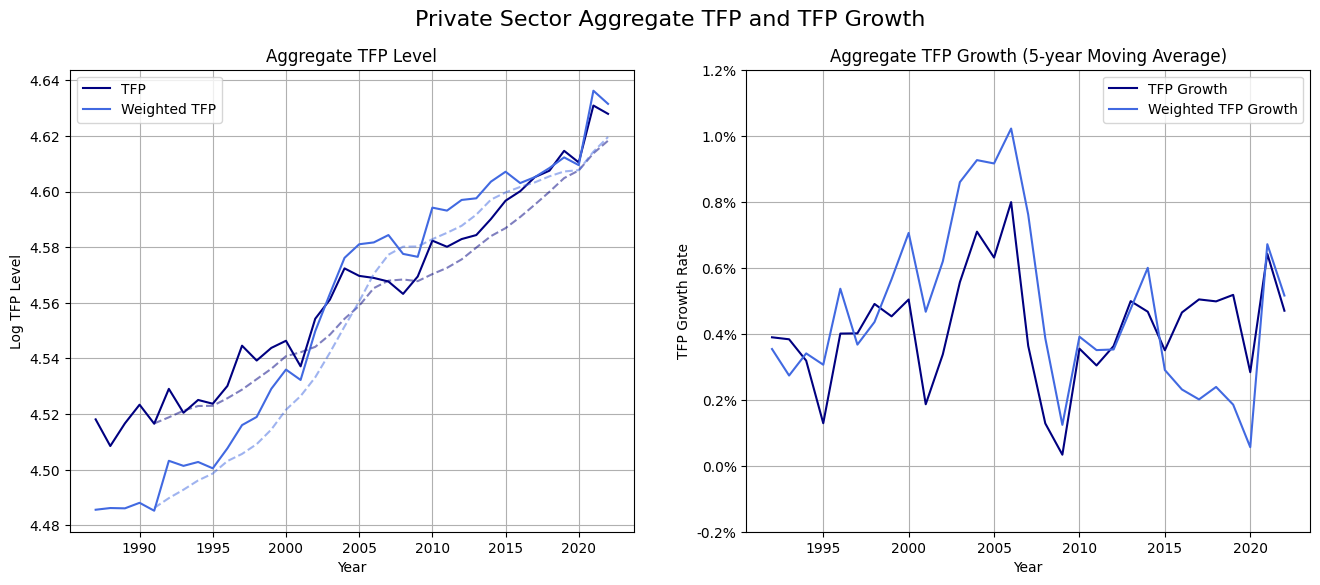

In [45]:
df = data[["Year", "NAICS", "TFP", "TFP_growth", "output_share"]]

aggregate_tfp = df.groupby('Year').agg(
    TFP=('TFP', 'mean'),
).reset_index()

aggregate_tfp["weighted_TFP"] = df.groupby('Year').apply(
    lambda x: np.average(x['TFP'], weights=x['output_share']),
    include_groups=False
).reset_index(drop=True)

aggregate_tfp_growth = df.groupby('Year').agg(
    TFP_growth=('TFP_growth', 'mean'),
).reset_index()

aggregate_tfp_growth["weighted_TFP_growth"] = df.groupby('Year').apply(
    lambda x: np.average(x['TFP_growth'], weights=x['output_share']),
    include_groups=False
).reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Private Sector Aggregate TFP and TFP Growth', fontsize=16)

ax1.plot(aggregate_tfp['Year'], np.log(aggregate_tfp['TFP']), label='TFP', color='navy')
ax1.plot(aggregate_tfp['Year'], np.log(aggregate_tfp['weighted_TFP']), label='Weighted TFP', color='royalblue')

ax1.plot(aggregate_tfp['Year'], np.log(aggregate_tfp['TFP']).rolling(5, min_periods=5).mean(), color='navy', linestyle='--', alpha=0.5)
ax1.plot(aggregate_tfp['Year'], np.log(aggregate_tfp['weighted_TFP']).rolling(5, min_periods=5).mean(), color='royalblue', linestyle='--', alpha=0.5)

ax1.set_xlabel('Year')
ax1.set_ylabel('Log TFP Level')
ax1.set_title('Aggregate TFP Level')
ax1.legend()
ax1.grid(True)

ax2.plot(aggregate_tfp_growth['Year'], (aggregate_tfp_growth['TFP_growth'].rolling(5, min_periods=5).mean() * 100), label='TFP Growth', color='navy')
ax2.plot(aggregate_tfp_growth['Year'], (aggregate_tfp_growth['weighted_TFP_growth'].rolling(5, min_periods=5).mean() * 100), label='Weighted TFP Growth', color='royalblue')

ax2.set_yticks([-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax2.set_yticklabels([f'{tick:0.1f}%' for tick in ax2.get_yticks()])

ax2.set_xlabel('Year')
ax2.set_ylabel('TFP Growth Rate')
ax2.set_title('Aggregate TFP Growth (5-year Moving Average)')
ax2.legend()
ax2.grid(True)

plt.show()

### Sectoral level

In [30]:
# group the data by NAICS industry, determine the change in tfp_growth from 1988 to 2022
df = data[["NAICS", "Industry", "Year", "TFP_growth"]].copy()

To reduce the volatility of the data, we will use a 5 year moving average to analyse the trends in productivity growth. This is because, annual data is subject to idiosyncratic shocks and is also vulnerable to business cycles. The 5 year moving average smooths out these shocks and cycles, allowing us to see the underlying trend in productivity growth.

In [50]:
# calculate five year moving average for TFP_growth, grouped by NAICS
df["TFP_growth_5yr"] = df.groupby("NAICS")["TFP_growth"].transform(
    lambda x: x.rolling(5, min_periods=5).mean()
)

average_growth = df[["NAICS", "TFP_growth"]].groupby("NAICS").mean()
average_growth.sort_values("TFP_growth", ascending=False, inplace=True)
average_growth

/var/folders/mh/f7pm6fzn655fqkxvm3d_gcq80000gn/T/ipykernel_15446/3627045648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TFP_growth_5yr"] = df.groupby("NAICS")["TFP_growth"].transform(


,TFP_growth
NAICS,
21,0.012906
11,0.011275
51,0.009996
42,0.009769
22,0.008409
MN,0.008137
54,0.007498
56,0.004829
72,0.004161


## Is there a relationship between productivity growth and creative destruction?

Here I will use a panel regression that includes industry and time fixed effects. The panel regression will allow us to control for unobserved heterogeneity across industries and time periods, which can help us isolate the effect of creative destruction on productivity growth. The fixed effects will also help us control for any time-invariant characteristics of the industries that may be correlated with productivity growth.

In [33]:
df = data.copy()
df.dropna(inplace=True)

df = df.set_index(['NAICS', 'Year'])

exog_vars = ['firm_death_rate', 'firm_birth_rate', 'job_reallocation_rate']
exog = df[exog_vars]
exog = sm.add_constant(exog)
dependent = df['TFP_growth']

model = PanelOLS(dependent, 
                exog, 
                entity_effects=True,  # NAICS fixed effects
                time_effects=True)    # Year fixed effects

results = model.fit()

print(results.summary.tables[0])

                          PanelOLS Estimation Summary                           
Dep. Variable:             TFP_growth   R-squared:                        0.0112
Estimator:                   PanelOLS   R-squared (Between):             -0.7141
No. Observations:                 594   R-squared (Within):               0.0088
Date:                Wed, Apr 23 2025   R-squared (Overall):             -0.0144
Time:                        16:16:04   Log-likelihood                    1251.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.0336
Entities:                          17   P-value                           0.1081
Avg Obs:                       34.941   Distribution:                   F(3,540)
Min Obs:                       34.000                                           
Max Obs:                       35.000   F-statistic (robust):             2.0336
                            